<a href="https://colab.research.google.com/github/omkardpatil/conformal_cooling_channels_design_optimization/blob/main/custom_cut_FE_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
import fenics
from fenics import *
from mshr import *
from math import *
clear_output()

In [ ]:
# define cut boundary from domain
# smallest unit 0.1*0.1
# define domain -0.9 to +0.9 in  x and y
# constrains continuous cut only in x and y ie not diagonal
# number of cuts 1

In [ ]:
#domain to cut -0.9 to +0.9
# 18*18
# -0.9+0.1*i

def get_mesh(remove):
  domain = Rectangle(Point(-1.0,-1.0), Point(1.,1.))
  l,w = remove.shape
  m=1.8/w
  for i in range(l):
    for j in range(w):
      if(remove[i,j]):
        domain = domain - Rectangle(Point(-0.9+m*i,-0.9+m*j), Point(-0.9+m*(i+1),-0.9+m*(j+1)))
  mesh = generate_mesh ( domain, 10 )
  return mesh

In [ ]:
import numpy as np
def get_matrix(size):
  remove = np.zeros((size,size))
  remove[2][2]=1
  remove[1][0]=1
  remove[2][1]=1
  remove[1][2]=1
  return remove

In [ ]:
size=8

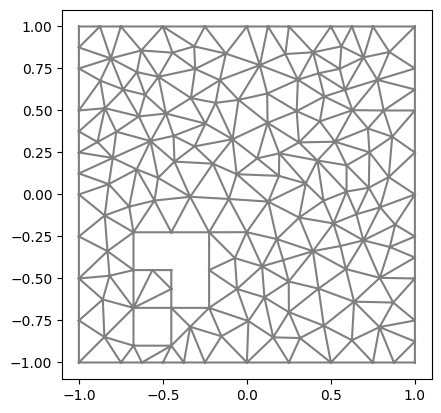

In [ ]:
remove = get_matrix(size)
mesh = get_mesh(remove)
plot(mesh)

In [ ]:
def work(mesh, u, to_print):
  # Define your mesh and function space
  V = FunctionSpace ( mesh, "Lagrange", 1 )

  # Create a function to interpolate 'u' to the function space
  u_interpolated = interpolate(u, V)

  # Get the values of 'u' at all nodes
  u_values = u_interpolated.vector().get_local()
  np_u = np.array(u_values)
  # Use np.ceil to round up each element to the nearest integer
  integer_array = np.ceil(np_u).astype(int)
  unique_elements, counts = np.unique(integer_array, return_counts=True)
  element_count_dict = dict(zip(unique_elements, counts))
  fitness=0
  for i, j in element_count_dict.items():
      r=i-temp_threshold_for_fitness
      if(r>0):
          fitness+=(j*j*r)
  if(to_print):
    print("Fitness value : ", fitness)
  return fitness

In [ ]:
import math
def is_point_near_square(point, square_bottom_left, edge_length,m):
    square_center = (
        square_bottom_left[0] + edge_length / 2,
        square_bottom_left[1] + edge_length / 2
    )

    distance = math.sqrt(
        (point[0] - square_center[0]) ** 2 +
        (point[1] - square_center[1]) ** 2
    )

    return distance < edge_length*m

In [ ]:
remove = get_matrix(size)
multiplyer=0.72
def on_edge(x):
    l,w = remove.shape
    m=1.8/w
    edge_length=m
    for i in range(l):
      for j in range(w):
        if(remove[i][j]):
          square_bottom_left=[-0.9+m*i,-0.9+m*j]
          ans= is_point_near_square(x, square_bottom_left, edge_length, multiplyer)
          if ans:
            return True
    return False

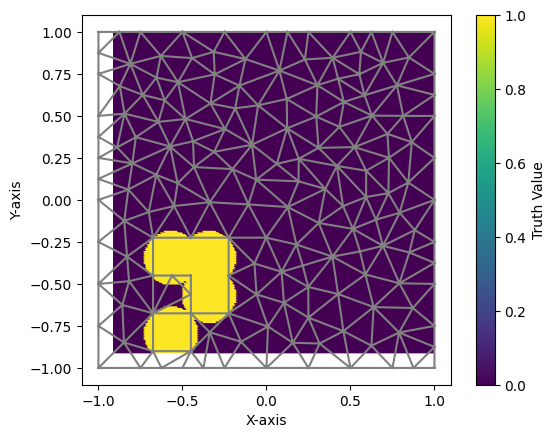

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

my_array = np.arange(-0.9, 1.0, 0.01)
x, y = np.meshgrid(my_array, my_array)
points = np.column_stack((x.ravel(), y.ravel()))

c_values=np.zeros(points.shape[0])
i=0
for point in points:
  c_values[i] = on_edge(point)
  i=i+1

point_size=5
plt.scatter(*zip(*points), c=c_values, cmap='viridis',  s=point_size)
plot(mesh)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(label='Truth Value')
plt.show()

In [ ]:
import numpy as np
def get_matrix(size):
  remove = np.zeros((size,size))
  remove[2][2]=1
  remove[1][0]=1
  remove[2][1]=1
  remove[1][2]=1
  return remove

In [ ]:
from fenics import *
from mshr import *
from math import *
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

temp_threshold_for_fitness=35
temp_threshold_for_stopping=0
t0=0.2 #time for which hot plastic will be in contact
#  Define time things
t_init = 0.0
t_final = 3.0
t_num = 30
u_origin=[]


def heat_implicit (remove_,save_file, to_print, store_u_origin, folder_name):

  if not os.path.exists(folder_name):
    os.makedirs(folder_name)
  mesh = get_mesh(remove_)

  plot ( mesh, title = 'heat_implicit Mesh' )
  filename = folder_name+'heat_implicit_mesh.png'
  plt.savefig ( filename )
  plt.show()
  print('Graphics saved as "%s"' % ( filename ) )
  plt.close ()

  V = FunctionSpace ( mesh, "Lagrange", 1 )

  #rectangle
  rect_u = 150.0
  def rect_on ( x, on_boundary ):
    return ( on_boundary and near(x[1],1))
  rect_bc = DirichletBC ( V, rect_u, rect_on )

  #edge
  fluid_u = 20.0
  fluid_bc = DirichletBC ( V, fluid_u, on_edge)
  bc_new = [fluid_bc]
  bc = [fluid_bc, rect_bc]

#  Define the trial functions (u) and test functions (v).
  u = TrialFunction ( V )
  v = TestFunction ( V )


#  The diffusivity is a constant.
  k = Constant ( 1.0 )
#  The source term is zero.
  f = Constant ( 0.0 )
  dt = ( t_final - t_init ) / t_num

#  Create U_INIT.
  u_init = Expression ( "40.0", degree = 10 )
  u_old = interpolate ( u_init, V )
  fvt = ( u_old + dt * f ) * v * dx
  Auvt = u * v * dx + dt * dot ( grad(u), grad(v) ) * dx
  u = Function ( V )
  t = t_init
  v_min=20
  v_max=150
  for j in range ( 0, t_num + 1):
    #print("Time now  ", j, t)
    if ( j % 2 == 0 ):
      label = 'Time = %g' % ( t )
      if(save_file):#########################################################################################################
        min_value = fluid_u
        max_value = rect_u
        mappable = plot( u_old, title = label ,cmap='viridis', norm=SymLogNorm(linthresh=0.03, linscale=0.03, vmin=v_min, vmax=v_max))
        cbar = plt.colorbar(mappable)
        filename = folder_name+'heat_implicit_solution_%d.png' % ( j )
        plt.savefig ( filename )
        print ( '  Graphics saved as "%s"' % ( filename ) )
      else:
        plot ( u_old, title = label )
      if(store_u_origin):
        u_origin.append(u(0.0,0.0))
      plt.show()
      #plt.close()
    t = t + dt
    if(t>t0):
      bc=bc_new
    solve ( Auvt == fvt, u, bc )

    u_old.assign ( u )
    max_value = u.vector().max()
    if(max_value<temp_threshold_for_stopping):
      if(to_print):
        print("Time required for cooling : ", t)
      fitness1 = work(mesh, u, to_print)
      fitness2 = exp(3)
      return fitness1*fitness2, u_old, mesh
  if(to_print):
      print("Time required for cooling : ", t)
  fitness1 = work(mesh, u, to_print)
  fitness2 = exp(3)
  return fitness1*fitness2

def heat_implicit_test (remove, save_file, to_print, store_u_origin, folder_name):
  level = 30
  set_log_level ( level )
  return heat_implicit(remove,save_file, to_print, store_u_origin, folder_name)

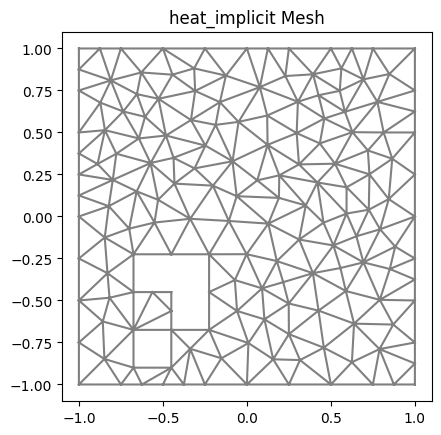

Graphics saved as "results1/heat_implicit_mesh.png"
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00427699 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.31518 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

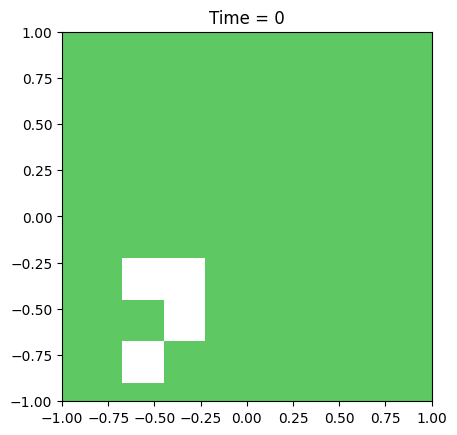

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_482818058e0569670834382e23b951b094f4114a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_63, f_65]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.1085 seconds.

INFO:FFC:Compiler stage

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00312781 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0269539 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00640631 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0206723 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00553155 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0183425 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_344a17ec3c8d9c2a51428d47ec335d9ec4ccc4b6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0521634 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

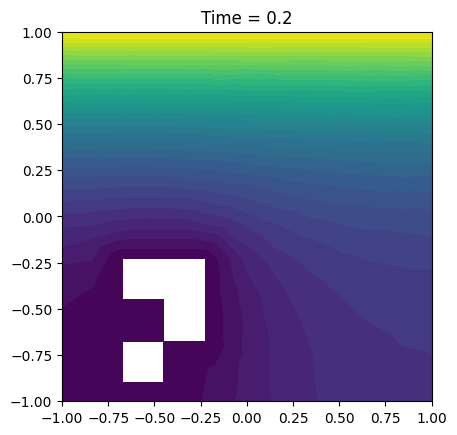

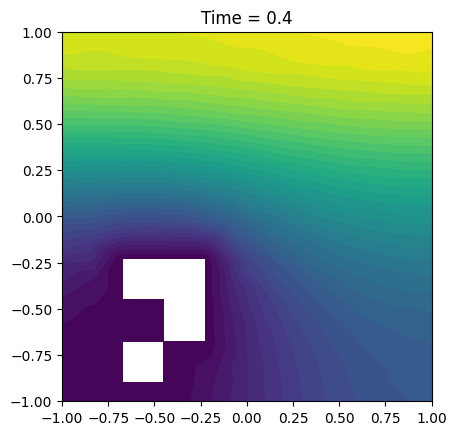

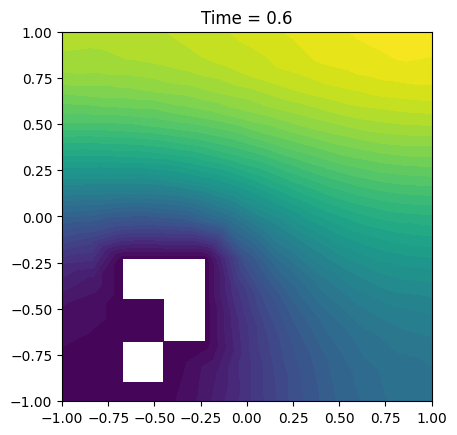

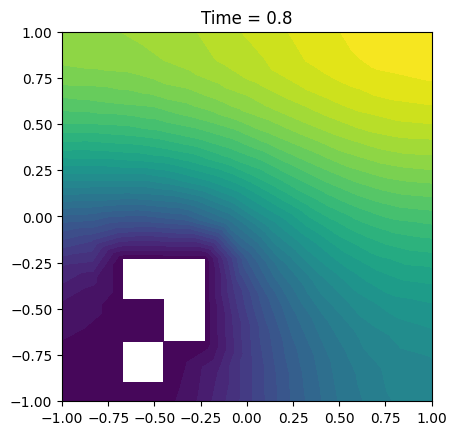

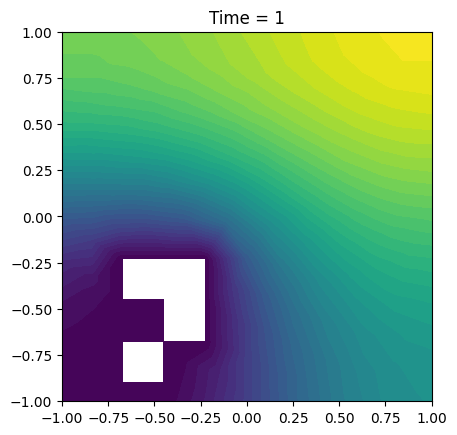

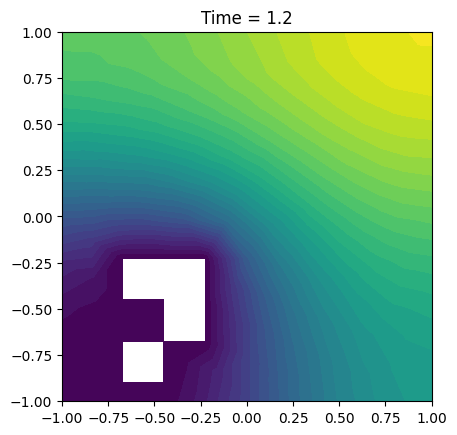

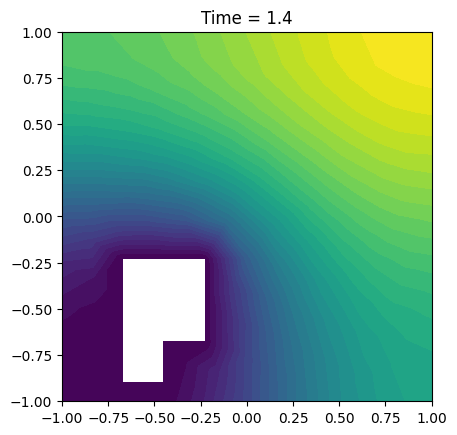

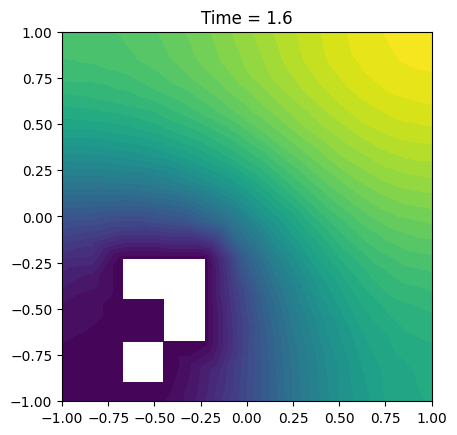

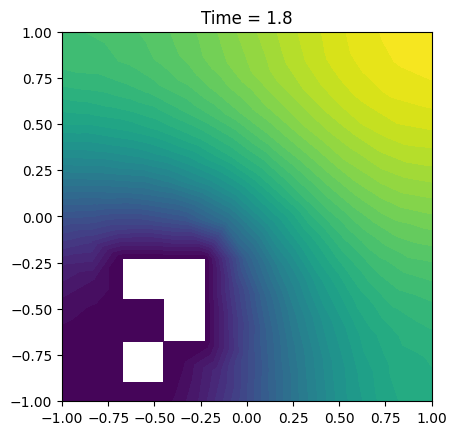

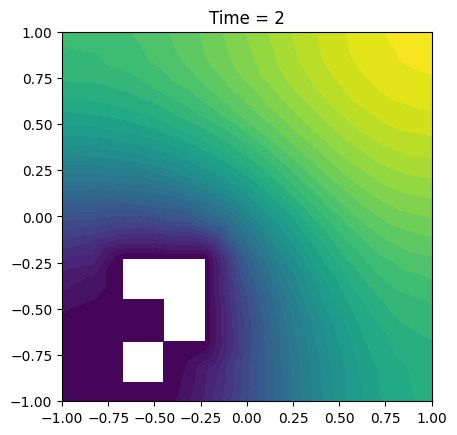

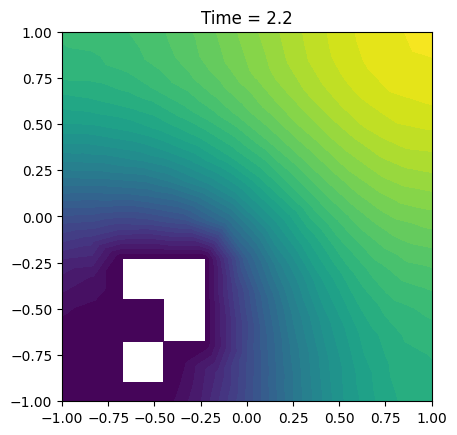

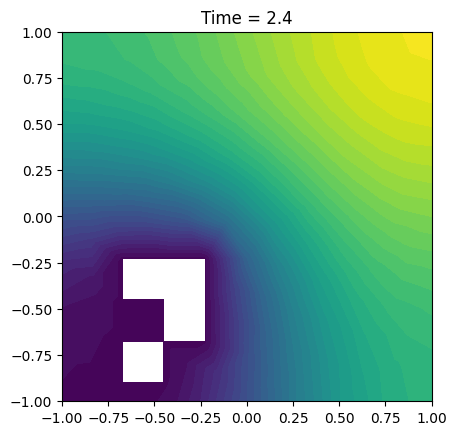

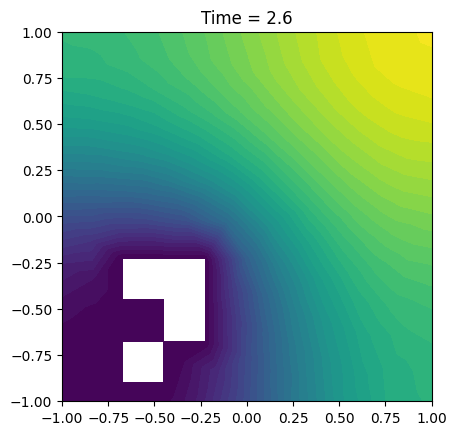

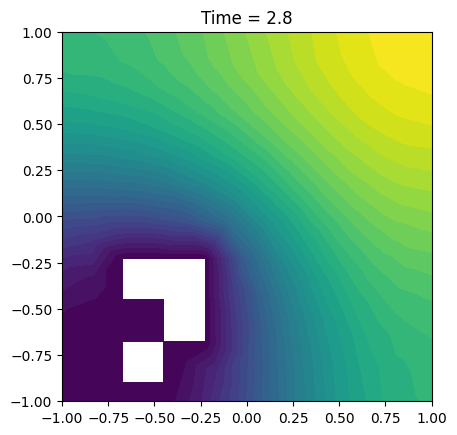

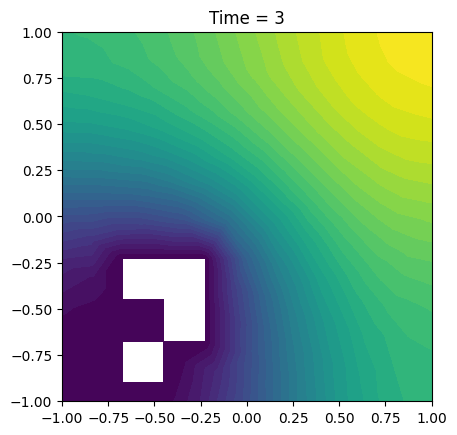

0.0


In [ ]:
remove_ = get_matrix(size)
folder_name='results1/'

ans = heat_implicit_test (remove_, save_file=False, to_print = False, store_u_origin=False, folder_name=folder_name)
#clear_output()
print(ans)

In [ ]:
#!zip -r /content/myfolder1.zip /content/results1
#clear_output()

In [ ]:
import numpy as np
def get_matrix2(size):
  mat = np.array([[0., 1., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])
  mat = np.flip(mat, axis=0)
  return mat.T

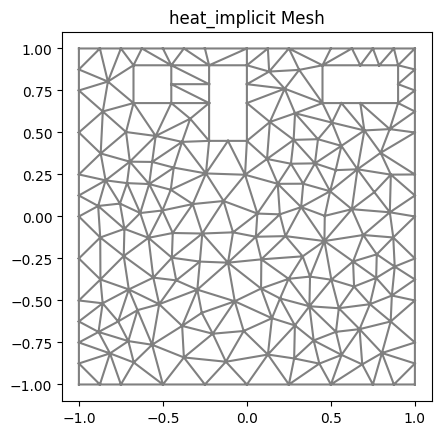

Graphics saved as "results4/heat_implicit_mesh.png"
  Graphics saved as "results4/heat_implicit_solution_0.png"


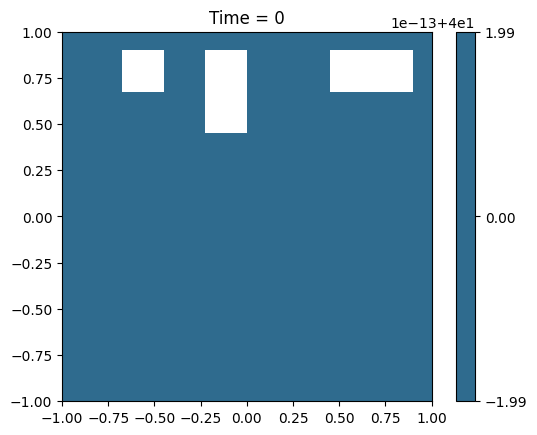

  Graphics saved as "results4/heat_implicit_solution_2.png"


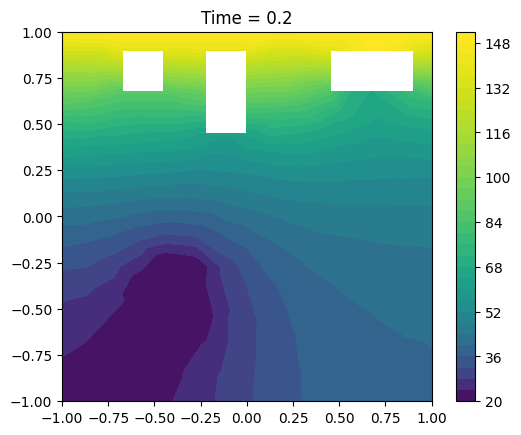

  Graphics saved as "results4/heat_implicit_solution_4.png"


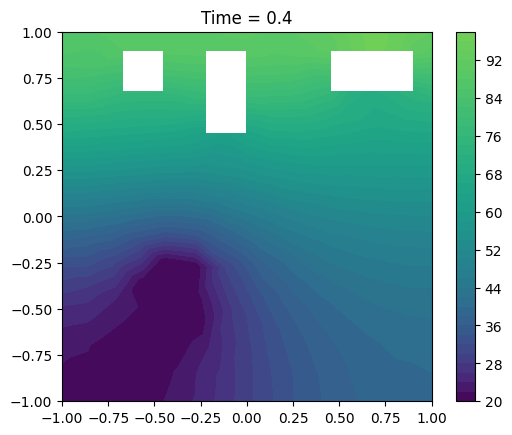

  Graphics saved as "results4/heat_implicit_solution_6.png"


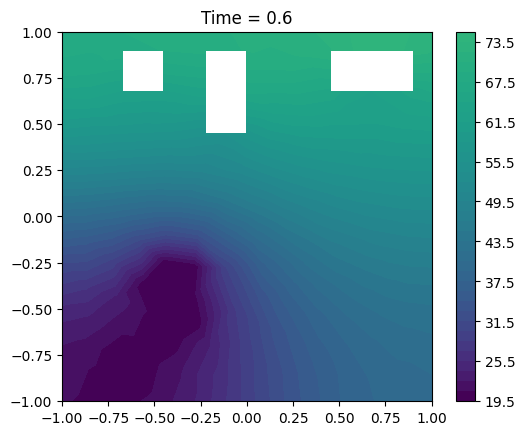

  Graphics saved as "results4/heat_implicit_solution_8.png"


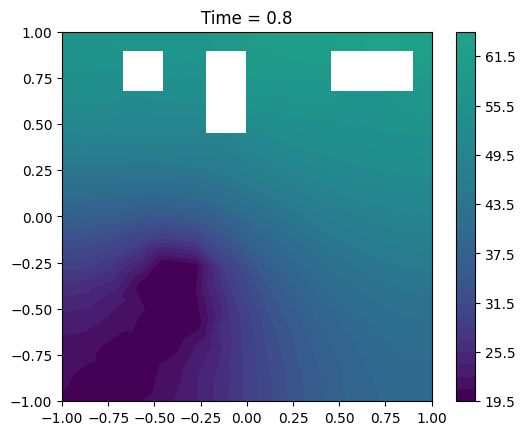

  Graphics saved as "results4/heat_implicit_solution_10.png"


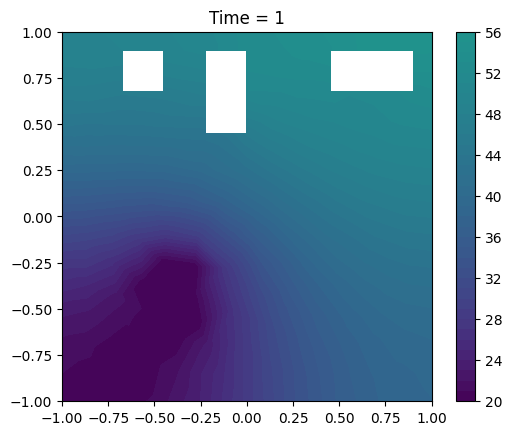

  Graphics saved as "results4/heat_implicit_solution_12.png"


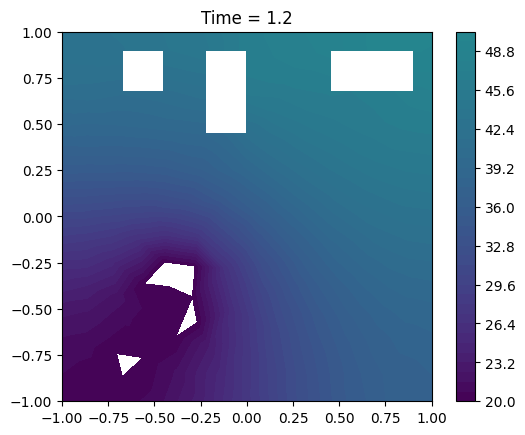

  Graphics saved as "results4/heat_implicit_solution_14.png"


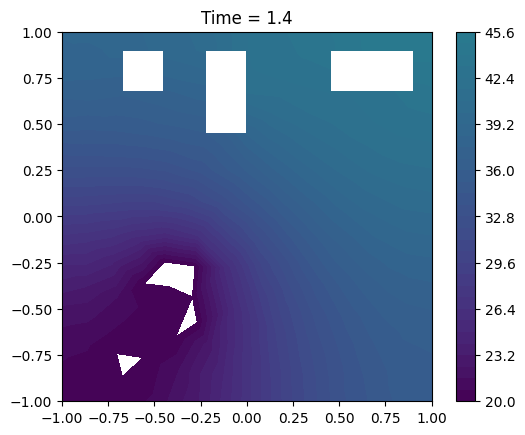

  Graphics saved as "results4/heat_implicit_solution_16.png"


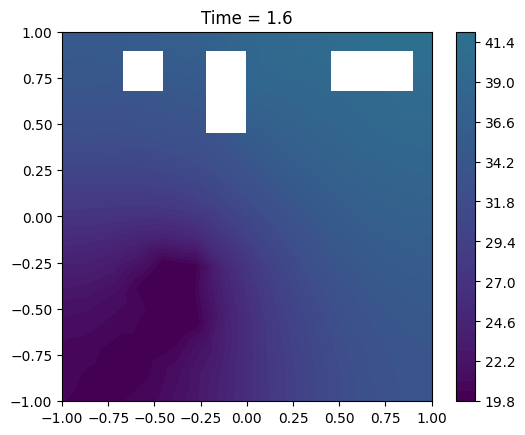

  Graphics saved as "results4/heat_implicit_solution_18.png"


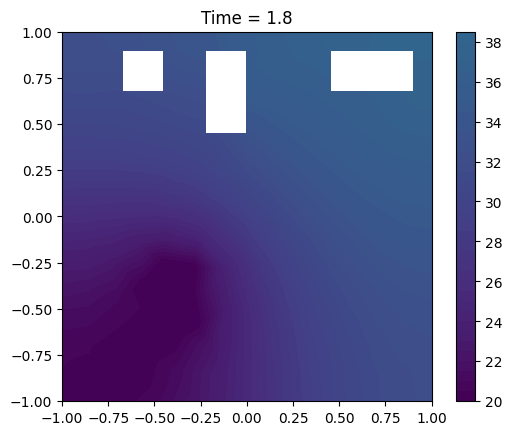

  Graphics saved as "results4/heat_implicit_solution_20.png"


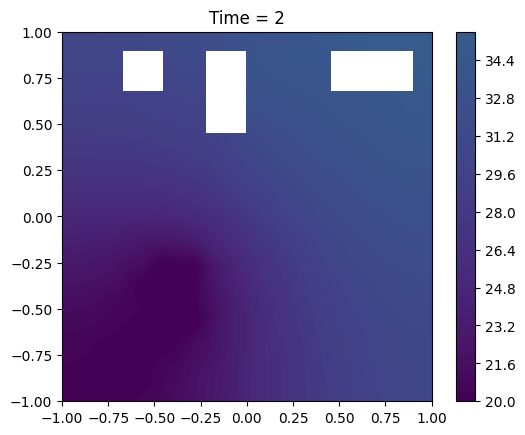

  Graphics saved as "results4/heat_implicit_solution_22.png"


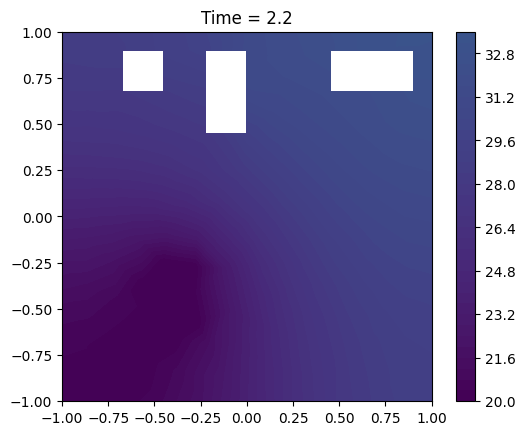

  Graphics saved as "results4/heat_implicit_solution_24.png"


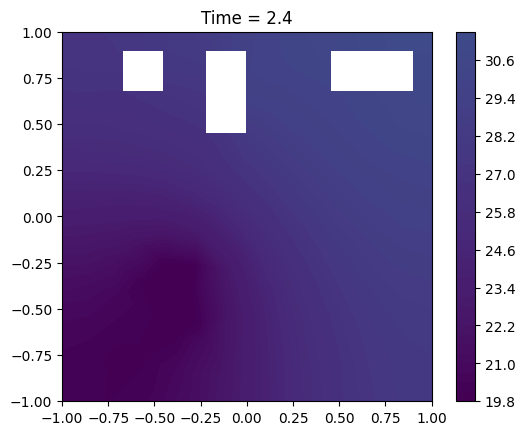

  Graphics saved as "results4/heat_implicit_solution_26.png"


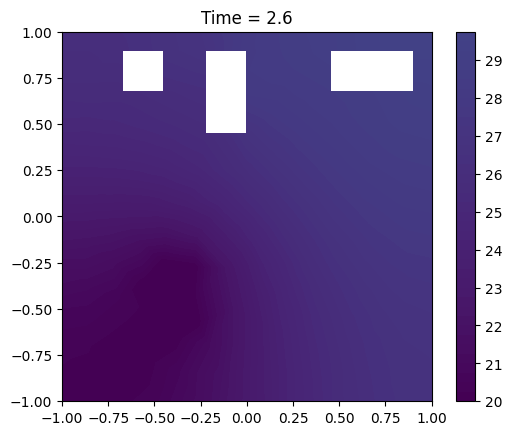

  Graphics saved as "results4/heat_implicit_solution_28.png"


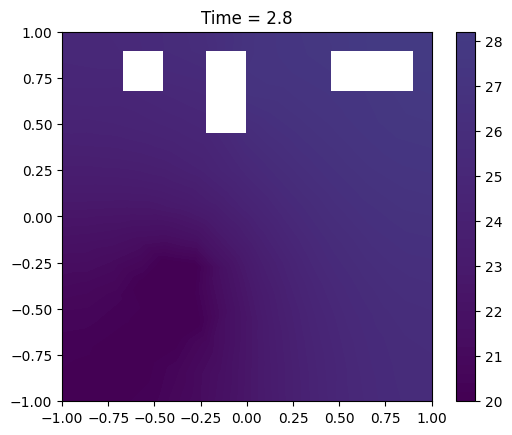

  Graphics saved as "results4/heat_implicit_solution_30.png"


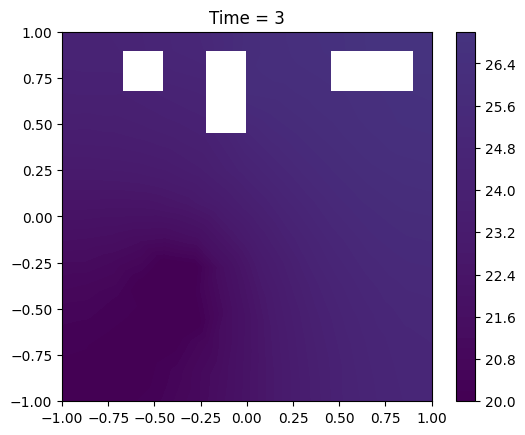

0.0


In [ ]:
remove_ = get_matrix2(size)
folder_name='results4/'

ans = heat_implicit_test (remove_, save_file=True, to_print = False, store_u_origin=False, folder_name=folder_name)
#clear_output()
print(ans)

In [ ]:
!zip -r /content/myfolder4.zip /content/results4
clear_output()